# Aerial Image Segmentation From Online Maps

Building a model for a segmentation task. The [dataset](https://zenodo.org/record/1154821/) used here is taken from *Learning Aerial Image Segmentation From Online Maps*

### import libraries

In [7]:
import numpy as np
from skimage import transform as sk_transform
from skimage import img_as_float
from skimage.io import imread, imshow, imsave
from matplotlib import pyplot as plt
import os
from glob import glob
import json
import shutil
from datetime import datetime
import dload  # for windows user install ssl and add to windows system path https://slproweb.com/products/Win32OpenSSL.html to enable ssl
import requests, zipfile, io # if dload not working in jupyter notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import cv2

### Config file to make user defined inputs

```json
    "data": {
        "image_size_full" : [2208, 2208],
        "split": 4,
        "train_percentage": 80,
        "image_resize": 300,
        "overlay": false,
        "city" : ["berlin"],
        "url" : ["https://zenodo.org/record/1154821/files/berlin.zip"]
    },

    "model":{
        "arch" : "net_Unet" 
    },

    "train":{
        "mode" : "train",                   
        "batch_size" :  5,                  
        "shuffle" : true,               
        "num_epochs" : 10,                
        "num_workers" : 5,                
        "learning_rate" : 1e-4,           
        "learning_rate_decay" : 4e-5,          
        "out_dir" : ""  
    }
```

### set project directory and load config file

In [12]:
# set project directory
ROOT_DIR = os.path.dirname(os.getcwd())

## Download the dataset

The following lines download the dataset. You could also add other cities from the dataset to your training pipeline.

Make sure the city and url are filled in config.json

If the dataset is already available, unzip and place it in the ```data/raw/``` directory


**Downloaded dataset:**

Berlin - 200 images and labels
* ```project_directory_home/data/raw/berlin/```

In [9]:
# config file
with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
    config = json.load(json_file)

Ndataset = 0
download_path = os.path.join(ROOT_DIR, 'data', 'raw')
cities = config['data']['city']
urls = config['data']['url']

if len(urls) == len(cities):
    Ndataset = len(urls)
else:
    print("Number of entries in city and url from config json did not match")

for count in range(Ndataset):
    if not os.path.exists(download_path + "/" + cities[count].lower()):
        os.makedirs(download_path + "/" + cities[count].lower())
#         dload.save_unzip(urls[count],download_path)
        r = requests.get(urls[0])
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(download_path)
        print ("Downloaded the {} dataset".format(cities[count].lower()))

Downloaded the potsdam dataset


## Exploration of the dataset

### Overlay 

In [13]:
def overlay(image, mask, alpha=1.0):
    img_big = imread(image)
    img_big = img_big[0:image_size_full[0], 0:image_size_full[1], :]  # cropping
    label_big = imread(mask)
    label_big = label_big[0:image_size_full[0], 0:image_size_full[1], :]  # cropping
    img = cv2.addWeighted(img_big, alpha, label_big, 1.0-alpha , 0)
    return img

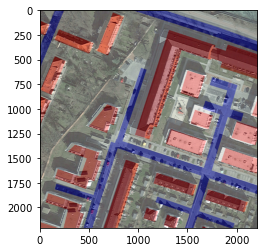

In [14]:
# config file
with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
    config = json.load(json_file)
    
image_size_full = config['data']['image_size_full'] #read this portion for uniform size and to be divisible by 16
# reading sample aerial image
img_name = "../data/raw/berlin/berlin23_image.png"
label_name = "../data/raw/berlin/berlin23_labels.png"
plt.imshow(overlay(img_name, label_name, alpha=0.7))

### Process image 

### Edit config.json to download additional cities dataset.

you can find it in ```project_directory_home/config.json```

* image_size_full is fixed with 2208 to make it divisible by 16
* split is fixed with 4 to make 4x4 grid
* image_resize is fixed with 300 to resize each grid to 300x300 pixels
* train_percentage is fixed with 80% meaning 80% train set and 20% test set
* overlay is fixed with False to avoid saving overlayed imgs. Enable it to True to view overlayed images from raw dataset

* Other dataset can be included by modifying city and url fields.
    For example if chicago dataset is required
    add chicago and its web url to city and url repsectively.


```json
    "data": {
        "image_size_full" : [2208, 2208],
        "split": 4,
        "train_percentage": 80,
        "image_resize": 300,
        "overlay": false,
        "city" : ["berlin"],
        "url" : ["https://zenodo.org/record/1154821/files/berlin.zip"]
    }
```

### Process dataset

* Splits the every single image into 4x4 grid and reisze into 300x300 pixels
* Converting labels to 0: building red, 1 road blue, 2 BG white
* Add noisy pixels to 2 BG white
* Convert the processed labels into color (original format)
* Save the processed images and labels

**Processed dataset:**

Each image and its label is split into 4x4 patches and resized into 300x300pixels. In this way, it is efficient to run deep learning algorithms in my personal laptop (CPU only).  

Berlin - 3200 images and labels
* ```project_directory_home/data/interim/images```
* ```project_directory_home/data/interim/labels```


### convert to color image - 0: building red, 1 road blue, 2 BG white

In [15]:
# convert to color
def convert_to_color(label_one_hot, resize_dim):
    colorimg = np.zeros((resize_dim,resize_dim,3))
    for y in range(label_one_hot.shape[0]):
        for x in range(label_one_hot.shape[1]):
            if label_one_hot[y][x] == 0:
                colorimg[y][x][0]=255
                colorimg[y][x][1]=0
                colorimg[y][x][2]=0
            elif label_one_hot[y][x] == 1:
                colorimg[y][x][0]=0
                colorimg[y][x][1]=0
                colorimg[y][x][2]=255
            elif label_one_hot[y][x] == 2:
                colorimg[y][x][0]=255
                colorimg[y][x][1]=255
                colorimg[y][x][2]=255
    
    return colorimg

### Process the dataset

In [16]:
def overlay_img(image, mask, alpha=1.0):
    img = cv2.addWeighted(image, alpha, mask, 1.0-alpha , 0)
    return img

In [17]:
#process dataset

# config file
with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
    config = json.load(json_file)

image_size_full = config['data']['image_size_full']
process_path = os.path.join(ROOT_DIR, 'data', 'interim')
image_path = os.path.join(process_path, 'images')
label_path = os.path.join(process_path, 'labels')
# label_path_color = os.path.join(process_path, 'labels_color') 
overlay_path = os.path.join(download_path, 'overlay')

if not os.path.exists(image_path):
    os.makedirs(image_path)
if not os.path.exists(label_path):
    os.makedirs(label_path)
# if not os.path.exists(label_path_color):
#     os.makedirs(label_path_color)

for data in range(Ndataset):
    # get downloaded paths
    dl_image_path = glob(download_path + "/" + cities[data].lower() + "/*_image.png")
    dl_label_path = glob(download_path + "/" + cities[data].lower() + "/*_labels.png")

    if len(dl_image_path) != len(dl_label_path):
        print ("Number of images and labels for {} does not match".format(cities[data]))
    else:
        for idx in range(len(dl_image_path)):
            # original image
            img_big = imread(dl_image_path[idx])
            # cropping
            img_big = img_big[0:image_size_full[0], 0:image_size_full[1], :]  
            # original label
            label_big = imread(dl_label_path[idx])
            # cropping
            label_big = label_big[0:image_size_full[0], 0:image_size_full[1], :]

            if config['data']['overlay']:
                if not os.path.exists(overlay_path):
                    os.makedirs(overlay_path)

                overlay_img = overlay_img(img_big, label_big, alpha=0.7)
                # save it to raw folder
                fname_overlay = os.path.join(overlay_path,  os.path.basename(dl_image_path[idx])[:-9]  + "overlay" + ".png")

                imsave(fname=fname_overlay, arr=overlay_img, check_contrast=False)


            # spliting image to 4x4 grid and resizing into 300x300 pixels 
            M = N = image_size_full[0]//config['data']['split']
            image_tiles = [img_big[x:x+M,y:y+N,:] for x in range(0,img_big.shape[0],M) for y in range(0,img_big.shape[1],N)]
            label_tiles = [label_big[x:x+M,y:y+N,:] for x in range(0,label_big.shape[0],M) for y in range(0,label_big.shape[1],N)]

            for tile in range(len(image_tiles)):
                # Converting labels to one-hot
                # 0: building red, 1 road blue, 2 BG white
                label_one_hot = 0.0 * image_tiles[tile]  

                # building channel 0
                label_one_hot[:, :, 0] = 1 * (
                    np.logical_and(np.equal(label_tiles[tile][:, :, 0], 255), np.equal(label_tiles[tile][:, :, 2], 0)))

                # road channel 1
                label_one_hot[:, :, 1] = 1 * (
                    np.logical_and(np.equal(label_tiles[tile][:, :, 0], 0), np.equal(label_tiles[tile][:, :, 2], 255)))

                # background, channel 2
                label_one_hot[:, :, 2] = 1 * (
                    np.logical_and(np.equal(label_tiles[tile][:, :, 0], 255), np.equal(label_tiles[tile][:, :, 1], 255)))

                label_one_hot[:, :, 2] = 1 * np.logical_and(label_one_hot[:, :, 2], np.equal(label_tiles[tile][:, :, 2], 255))

                # fixing some noisy, left-out pixels, assigning them to BG . These are the ones ==0 in all 3 channels
                all_zeros = np.logical_and(np.equal(label_one_hot[:, :, 0], 0), np.equal(label_one_hot[:, :, 1], 0))
                all_zeros = np.logical_and(all_zeros, np.equal(label_one_hot[:, :, 2], 0))

                # add these noisy pixels to background
                label_one_hot[:, :, 2] += 1 * all_zeros   

                # resizing
                label_one_hot = sk_transform.resize(label_one_hot, (config['data']['image_resize'], config['data']['image_resize']), preserve_range=True)
                img_single = sk_transform.resize(image_tiles[tile], (config['data']['image_resize'], config['data']['image_resize']), preserve_range=True)


                label_one_hot = np.argmax(label_one_hot, 2)

                label_color = convert_to_color(label_one_hot, config['data']['image_resize'])

                fname_images = os.path.join(image_path, os.path.basename(dl_image_path[idx])[:-4] + "_tile" + str(tile) + ".png")
                fname_label = os.path.join(label_path, os.path.basename(dl_label_path[idx])[:-4] + "_tile" + str(tile) + ".png")
                # fname_label_color = os.path.join(label_path_color, os.path.basename(dl_label_path[idx])[:-4] + "_tile" + str(tile) + ".png")

                # save it to interim folder
                imsave(fname=fname_images, arr=img_single, check_contrast=False)
                # imsave(fname=fname_label, arr=label_one_hot, check_contrast=False)
                imsave(fname=fname_label, arr=img_as_float(label_color), check_contrast=False)

    print ("Processed the {} dataset".format(cities[data].lower()))

Lossy conversion from float64 to uint8. Range [0.0, 254.14000000000004]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.90000000000003]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 250.88799999999986]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 pri

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.94279999999998]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.41399999999902]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.94960000000003]. Convert image to uint8 pri

Lossy conversion from float64 to uint8. Range [0.0, 253.63999999999993]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.19]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.1036]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 240.0988]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to sup

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.56759999999997]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 234.2900000000002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving t

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.82520000000005]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress t

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 245.28800000000143]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.97479999999996]. Convert image to uint8 prior to saving 

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.97999999999996]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress t

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.57399999999998]. Convert image to uint8 prior to saving to suppress t

Lossy conversion from float64 to uint8. Range [0.0, 253.6339999999998]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 252.78919999999997]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving t

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 251.45399999999893]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 251.61999999999983]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving 

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 251.55000000000013]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 254.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 253.87000000000012]. Convert image to uint8 prior to saving 

Processed the potsdam dataset


### Build a segmentation model
Build a segmentation model to segment buildings and roads from the dataset. 

### Prepare train and test set

In [18]:
# config file
with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
    config = json.load(json_file)

train_test_split = config['data']['train_percentage']

process_path = os.path.join(ROOT_DIR, 'data', 'processed')
# train path
image_train_path = os.path.join(process_path, 'train', 'images')
label_train_path = os.path.join(process_path, 'train', 'labels')
# test path
image_test_path = os.path.join(process_path, 'test', 'images')
label_test_path = os.path.join(process_path, 'test', 'labels')

#create directories
if not os.path.exists(image_train_path):
    os.makedirs(image_train_path)
if not os.path.exists(label_train_path):
    os.makedirs(label_train_path)
if not os.path.exists(image_test_path):
    os.makedirs(image_test_path)
if not os.path.exists(label_test_path):
    os.makedirs(label_test_path)

# check existence of interim dataset
images_interim_path = os.path.join(ROOT_DIR, 'data', 'interim', 'images')
labels_interim_path = os.path.join(ROOT_DIR, 'data', 'interim', 'labels')
if not os.path.exists(images_interim_path) and not os.path.exists(labels_interim_path):
    print ("Please run the make_dataset script to process the dataset before run this script")
else:
    dl_image_path = glob(images_interim_path + "/*.png")
    dl_label_path = glob(labels_interim_path + "/*.png")

    pairs = list(zip(dl_image_path, dl_label_path))

    split = len(dl_image_path) * (train_test_split/100)

    train_set = pairs[:int(split)]
    test_set = pairs[int(split):]

    for train_file in train_set:
        shutil.copy(train_file[0], image_train_path)
        shutil.copy(train_file[1], label_train_path)

    for test_file in test_set:
        shutil.copy(test_file[0], image_test_path)
        shutil.copy(test_file[1], label_test_path)

    print ("Train and Test set are prepared successfully")

Train and Test set are prepared successfully


### Dataset loader

In [19]:
class Dataset(Dataset):
    def __init__(self, split_file_image, split_file_label, using_onehot):

        self.split_file_image = sorted(glob(split_file_image + "/*.png"))
        self.split_file_label = sorted(glob(split_file_label + "/*.png"))
        self.using_onehot = using_onehot

    def __len__(self):
        return len(self.split_file_image)

    def __getitem__(self, idx):

        # Reading aerial image
        img_name = self.split_file_image[idx]
        image_single = imread(img_name) / 255.0

        label_name = self.split_file_label[idx]
        label_single = imread(label_name)

        # splitting label

        # Converting labels to one-hot
        label_one_hot = 0.0 * image_single

        # building channel 0
        label_one_hot[:, :, 0] = 1 * (np.logical_and(
            np.equal(label_single[:, :, 0], 255),
            np.equal(label_single[:, :, 2], 0)))

        # road channel 1
        label_one_hot[:, :, 1] = 1 * (np.logical_and(
            np.equal(label_single[:, :, 0], 0),
            np.equal(label_single[:, :, 2], 255)))

        # background, channel 2
        label_one_hot[:, :, 2] = 1 * (np.logical_and(
            np.equal(label_single[:, :, 0], 255),
            np.equal(label_single[:, :, 1], 255)))

        label_one_hot[:, :, 2] = 1 * np.logical_and(
            label_one_hot[:, :, 2], np.equal(label_single[:, :, 2], 255))

        if not self.using_onehot:
            label_one_hot = np.argmax(label_one_hot, 2)

        return image_single, label_one_hot


def get_dataset(mode, config):
    # Get dataset object by its name and mode (train/test)

    # set data directory
    data_folder = ROOT_DIR

    if mode == 'train':
        split_file_image = os.path.join(data_folder, 'data', 'processed', mode,
                                        'images')
        split_file_label = os.path.join(data_folder, 'data', 'processed', mode,
                                        'labels')
    elif mode == 'test':
        split_file_image = os.path.join(data_folder, 'data', 'processed', mode,
                                        'images')
        split_file_label = os.path.join(data_folder, 'data', 'processed', mode,
                                        'labels')
    else:
        raise ValueError("Mode {} is unknown".format(mode))

    ds = Dataset(split_file_image, split_file_label, using_onehot=False)

    # preparing pytorch data loader
    ds_final = torch.utils.data.DataLoader(
        ds,
        batch_size=config['train']['batch_size'],
        shuffle=config['train']['shuffle'],
        num_workers=config['train']['num_workers'])

    return ds_final

### U-net

I  decided to go with U-Net for 2 reasons
* The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.
* Since it has shown success in many segmentation tasks, it could potentially serve as a benchmark for my next approach (need to do literature review).

Arxiv Link: 
<a href=https://arxiv.org/abs/1505.04597>Convolutional Networks for Biomedical Image Segmentation</a>

* UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.
* UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.

**UNet Architecture has 3 parts:**
* The Contracting/Downsampling Path
* Bottleneck
* The Expanding/Upsampling Path

**Downsampling Path:**
* It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.
* At each downsampling step we double the number of feature channels.

**Upsampling Path:**
* Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature map from the downsampling path, and two 3x3 convolutions, each followed by a ReLU.

**Skip Connection:**
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

**Final Layer:**
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

In [20]:
def count_trainable_parameters(model):  # to count trainable parameters
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


number_classes = 3  # building, road, background

########
# U-Net
########
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.inc = inconv(3, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, number_classes)

    def forward(self, x):
        x1 = self.inc(x.permute(0, 3, 1, 2))
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.softmax(x, dim = 1)

########
# light U-Net, half the features maps than the original
########
class Net_light(nn.Module):
    def __init__(self):
        super(Net_light, self).__init__()

        self.inc = inconv(3, 32)
        self.down1 = down(32, 64)
        self.down2 = down(64, 128)
        self.down3 = down(128, 256)
        self.down4 = down(256, 256)
        self.up1 = up(512, 128)
        self.up2 = up(256, 64)
        self.up3 = up(128, 32)
        self.up4 = up(64, 32)
        self.outc = outconv(32, number_classes)

    def forward(self, x):
        x1 = self.inc(x.permute(0, 3, 1, 2))
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.softmax(x, dim = 1)


########
# lighter U-Net, quarter the features maps than the original
########
class Net_lighter(nn.Module):
    def __init__(self):
        super(Net_lighter, self).__init__()

        self.inc = inconv(3, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 128)
        self.up1 = up(256, 64)
        self.up2 = up(128, 32)
        self.up3 = up(64, 16)
        self.up4 = up(32, 16)
        self.outc = outconv(16, number_classes)

    def forward(self, x):
        x1 = self.inc(x.permute(0, 3, 1, 2))
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.softmax(x, dim = 1)


class Q_Net_lighter(nn.Module):
    def __init__(self):
        super(Q_Net_lighter, self).__init__()

        self.inc = inconv(3, 16)
        self.down1 = down(16, 32)
        self.down2 = down(32, 64)
        self.down3 = down(64, 128)
        self.down4 = down(128, 128)
        self.up1 = up(256, 64)
        self.up2 = up(128, 32)
        self.up3 = up(64, 16)
        self.up4 = up(32, 16)
        self.outc = outconv(16, 1)

    def forward(self, x):
        x1 = self.inc(x.permute(0, 3, 1, 2))
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

### Metrics

The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output. 

I compute the IoU for building, road and background and the mean of all.

In [21]:
def IoU(predicted, labels, extra=False):
    p = torch.argmax(predicted[:, :, :, :], dim=1)

    # IoU of building, channel 0
    pred_build = torch.eq(p, torch.zeros(1).type('torch.LongTensor'))
    true_build = torch.eq(labels[:, :, :], torch.zeros(1).type('torch.LongTensor'))

    inter_build = torch.sum(pred_build * true_build)
    union_build = torch.sum(pred_build) + torch.sum(true_build) - inter_build
    iou_build = (inter_build.float()) /(union_build.float() + 1e-6)

    # IoU of road, channel 1
    pred_road = torch.eq(p, torch.ones(1).type('torch.LongTensor'))
    true_road = torch.eq(labels[:, :, :], torch.ones(1).type('torch.LongTensor'))

    inter_road = torch.sum(pred_road * true_road)
    union_road = torch.sum(pred_road) + torch.sum(true_road) - inter_road
    iou_road = (inter_road.float()) / (union_road.float() + 1e-6)

    # IoU of background, channel 2
    pred_bg = torch.eq(p, 2 * torch.ones(1).type('torch.LongTensor'))
    true_bg = torch.eq(labels[:, :, :], 2 * torch.ones(1).type('torch.LongTensor'))

    inter_bg = torch.sum(pred_bg * true_bg)
    union_bg = torch.sum(pred_bg) + torch.sum(true_bg) - inter_bg
    iou_bg = (inter_bg.float()) / (union_bg.float()  + 1e-6)

    # mean IoU
    if extra==True:
        mIoU = (iou_bg + iou_road + iou_build ) / 3.0  # mean IoU

        # frequency weighted IoU
        total_pix = torch.sum(true_build) + torch.sum(true_road) + torch.sum(true_bg)
        fwIoU = (iou_bg*torch.sum(true_bg) + iou_road*torch.sum(true_road) + iou_build*torch.sum(true_build) ) / total_pix.float()

        # pixel accuracy
        acc = ( inter_road + inter_build + inter_bg ) / total_pix.float()


        if total_pix == 0:
            print('Oops, total pix = 0')
            print('debug')
        return iou_build, iou_road, iou_bg, mIoU, fwIoU, acc

    return iou_build, iou_road, iou_bg

### Training parameters defined in config json

* If running this notebook in windows, set num_workers as 0
* Generally it is advised to start with with log scale learning rate, so I fixed it as 0.0001. 
* In many literatures, decaying learning rate observed to help both optimization and generalization. I decay the learning rate at every epoch by 4e-5 times.

```json
    "train":{
        "mode" : "train",                   
        "batch_size" :  5,                  
        "shuffle" : true,               
        "num_epochs" : 10,                
        "num_workers" : 0,                
        "learning_rate" : 1e-4,           
        "learning_rate_decay" : 4e-5,          
        "out_dir" : ""  
    }

```

* Since I approach this problem as multi-class classification tasks, cross entropy loss is used

### Train the model

Configuration:
{'mode': 'train', 'batch_size': 5, 'shuffle': True, 'num_epochs': 2, 'num_workers': 0, 'learning_rate': 0.0001, 'learning_rate_decay': 4e-05, 'out_dir': ''}
Data loaders have been prepared!
Network loaded. Starting training...
[1,     1 out of    62] loss: 1.120397, time = 5.954948
building IoU = tensor(0.1024), road IoU = tensor(0.0402), background IoU = tensor(0.1646)
[1,    26 out of    62] loss: 1.081494, time = 148.309305
building IoU = tensor(0.4427), road IoU = tensor(0.1282), background IoU = tensor(0.3196)
[1,    51 out of    62] loss: 1.056513, time = 151.811693
building IoU = tensor(0.4412), road IoU = tensor(0.2117), background IoU = tensor(0.3032)
End of epoch 1. Val loss is 1.0748030617833138
Following stats are only for the last batch of the test set:
building IoU = tensor(0.0844), road IoU = tensor(0.1281), background IoU = tensor(0.2782)
Model saved at epoch 1
[2,     1 out of    62] loss: 1.017468, time = 5.259522
building IoU = tensor(0.5917), road IoU

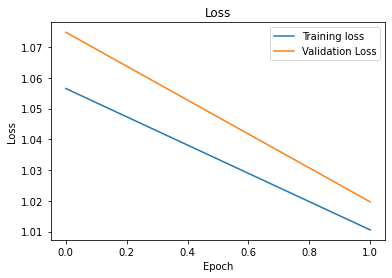

In [22]:
now = datetime.now()
out_dir = os.path.join(ROOT_DIR, 'models', now.strftime("%Y%m%d-%H%M%S"))

# setting output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
else:
    print('Folder already exists. overwriting the results......')

# config file
with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
    config = json.load(json_file)
    
print('Configuration:')
print(config['train'])

## Data loaders
mode = 'train'  # Training data loader
ds_train = get_dataset(mode, config)

mode = 'test'  # validation data loader
ds_test = get_dataset(mode, config)
print('Data loaders have been prepared!')

## Model
mode = 'train'
net = Net_lighter()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

print('Network loaded. Starting training...')

# weights for  # building, road, BG - To balance the classes
my_weight = torch.from_numpy(np.asarray([1, 2, 0.5])).type('torch.FloatTensor')
criterion = torch.nn.CrossEntropyLoss(weight=my_weight)

optim = torch.optim.Adam(net.parameters(),
                         lr=config['train']['learning_rate'],
                         weight_decay=config['train']['learning_rate_decay'])

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)

ep = config['train']['num_epochs']  # number of epochs

# loss logs
loss_train = 9999.0 * np.ones(ep)
temp_train_loss = 0
loss_val = 9999.0 * np.ones(ep)

# training the network
for epoch in range(ep):
    running_loss = 0.0
    running_ctr = 0

    # switch model to training mode, clear gradient accumulators
    net.train()

    # scheduler.step()  # update learning rate

    optim.zero_grad()

    t1 = datetime.now()

    for i, data in enumerate(ds_train, 0):
        optim.zero_grad()

        # reading images
        images = data[0].type('torch.FloatTensor')
        # labels
        labels = data[1].type('torch.LongTensor')

        predicted = net(images)

        loss = criterion(predicted, labels)

        loss.backward()

        optim.step()

        # print statistics
        running_loss += loss.item()
        running_ctr += 1
        if i % 25 == 0:
            t2 = datetime.now()
            delta = t2 - t1
            t_print = delta.total_seconds()
            temp_train_loss = running_loss / 25.0
            print('[%d, %5d out of %5d] loss: %f, time = %f' %
                  (epoch + 1, i + 1, len(ds_train), running_loss / running_ctr,
                   t_print))

            iou_build, iou_road, iou_bg = IoU(predicted, labels)
            print('building IoU = ' + str(iou_build) + ', road IoU = ' +
                  str(iou_road) + ', background IoU = ' + str(iou_bg))

            running_loss = 0.0
            running_ctr = 0
            t1 = t2

    net.eval()
    scheduler.step()  # update learning rate
    val_loss = 0

    with torch.no_grad():
        for i, data in enumerate(ds_test, 0):
            # reading images
            images = data[0].type('torch.FloatTensor')
            # labels
            labels = data[1].type('torch.LongTensor')

            predicted = net(images)

            loss = criterion(predicted, labels)

            # Val loss
            val_loss += loss.item()

        # print statistics
        val_loss = val_loss / len(ds_test)
        print('End of epoch ' + str(epoch + 1) + '. Val loss is ' +
              str(val_loss))

        print('Following stats are only for the last batch of the test set:')
        iou_build, iou_road, iou_bg = IoU(predicted, labels)
        print('building IoU = ' + str(iou_build) + ', road IoU = ' +
              str(iou_road) + ', background IoU = ' + str(iou_bg))

        # Model check point
        if val_loss < np.min(loss_val, axis=0):
            model_path = os.path.join(out_dir, "trained_model_checkpoint.pth")
#             torch.save(net, model_path)
            torch.save(net.state_dict(), model_path)
            print('Model saved at epoch ' + str(epoch + 1))

        # saving losses
        loss_val[epoch] = val_loss
        loss_train[epoch] = temp_train_loss

        temp_train_loss = 0  # setting additive losses to zero

print('Training finished')
# saving model
model_path = os.path.join(out_dir, "trained_model_end.pth")
# torch.save(net, model_path)
torch.save(net.state_dict(), model_path)
print('Model saved')

# Saving logs in a text file in the output directory
log_name = os.path.join(out_dir, "logging.txt")
with open(log_name, 'w') as result_file:
    result_file.write('Logging... \n')
    result_file.write('Validation loss ')
    result_file.write(str(loss_val))
    result_file.write('\nTraining loss  ')
    result_file.write(str(loss_train))

# saving loss curves
a = loss_val
b = loss_train

plt.figure()
plt.plot(b)
plt.plot(a)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Validation Loss'])
fname1 = str('loss.png')
plt.savefig(os.path.join(out_dir, fname1), bbox_inches='tight')

print('Training finished!!!')

### Evaluate the model

In [23]:
now = datetime.now()

# Compute evaluation this many times and then compute average
repeat_times = 10

out_dir = os.path.join(ROOT_DIR, 'models')

if not os.path.exists(out_dir):
    raise ValueError('The folder does not exist. Make sure the training has been completed before running this script')

latest_model = max(glob(out_dir + "/*"))
trained_model = glob(os.path.join(out_dir, latest_model) + "/*.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


segment_net = Net_lighter() 

# loading segmentation net
if len(trained_model) == 10:
    segment_net.load_state_dict(torch.load(os.path.join(out_dir, latest_model, trained_model[1])))
else:
    segment_net.load_state_dict(torch.load(os.path.join(out_dir, latest_model, trained_model[0])))

segment_net.eval()
segment_net.to(device)

# config file
with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
    config = json.load(json_file)

print('Network loaded...')
print(config)

## getting the dataset
mode = 'test'                 

ds_test = get_dataset(mode, config)
print('Data loaders have been prepared!')

iou_build = 0
iou_road = 0
iou_bg = 0
mIoU = 0
fwIou = 0
acc = 0


with torch.no_grad():
    for t in range(repeat_times):  # evaluate everything 10 times

        for i, data in enumerate(ds_test, 0):
            images = data[0].type('torch.FloatTensor') # reading images

            # labels
            labels = data[1].type('torch.LongTensor')

            # segmentation performance
            predicted = segment_net(images)
            i1, i2, i3, i4, i5, i6 = IoU(predicted, labels, extra=True)
            iou_build += i1
            iou_road += i2
            iou_bg += i3
            mIoU += i4
            fwIou += i5
            acc += i6

        print('Completed ' + str(t) + 'out of ' + str(repeat_times))


# average of segmentation numbers
iou_build /= ( len(ds_test)  * repeat_times)
iou_road /= (len(ds_test)  * repeat_times)
iou_bg /= (len(ds_test) * repeat_times)
mIoU /= (len(ds_test)  * repeat_times)
fwIou /= (len(ds_test)  * repeat_times)

acc /= (len(ds_test)  * repeat_times)


print('Building IoU on test set = ' + str(iou_build))
print('Road IoU on test set = ' + str(iou_road))
print('BG IoU on test set = ' + str(iou_bg))
print('mIoU on test set = ' + str(mIoU))
print('Frequency weighted IoU on test set = ' + str(fwIou))
print('Pixel accuracy on test set = ' + str(acc))

fname =  os.path.join(ROOT_DIR, 'reports', now.strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(fname):
    os.makedirs(fname)
fname = os.path.join(fname, 'eval_results.txt')

# saving results on disk
with open(fname, 'w') as result_file:
    result_file.write('Logging... \n')
    result_file.write('\nBuilding IoU on test set =   ')
    result_file.write(str(iou_build))
    result_file.write('\nRoad IoU on test set =   ')
    result_file.write(str(iou_road))
    result_file.write('\nBG IoU on test set =   ')
    result_file.write(str(iou_bg))
    result_file.write('\nMean IoU on test set =   ')
    result_file.write(str(mIoU))
    result_file.write('\nfrequency weighted IoU on test set =   ')
    result_file.write(str(fwIou))
    result_file.write('\nPixel accuracy on test set =   ')
    result_file.write(str(acc))

print('All done. Results saved in reports directory')

Network loaded...
{'data': {'image_size_full': [2208, 2208], 'split': 4, 'train_percentage': 80, 'image_resize': 300, 'overlay': False, 'city': ['potsdam'], 'url': ['https://zenodo.org/record/1154821/files/potsdam.zip']}, 'model': {'arch': 'net_Unet'}, 'train': {'mode': 'train', 'batch_size': 5, 'shuffle': True, 'num_epochs': 2, 'num_workers': 0, 'learning_rate': 0.0001, 'learning_rate_decay': 4e-05, 'out_dir': ''}}
Data loaders have been prepared!
Completed 0out of 10
Completed 1out of 10
Completed 2out of 10
Completed 3out of 10
Completed 4out of 10
Completed 5out of 10
Completed 6out of 10
Completed 7out of 10
Completed 8out of 10
Completed 9out of 10
Building IoU on test set = tensor(0.4521)
Road IoU on test set = tensor(0.1938)
BG IoU on test set = tensor(0.3712)
mIoU on test set = tensor(0.3390)
Frequency weighted IoU on test set = tensor(0.3775)
Pixel accuracy on test set = tensor(0.5044)
All done. Results saved in reports directory


## Create an inference function 

Creating a function which is able to make predictions on new images. The format will be identical to the original masks from the training data: 

  - Red color for buildings 
  - Blue color for streets
  - White color for everything else

### Patchify and Unpatchify

In [24]:
# merge image
def merge_image(imaage_set, config):
    image_size_full = config['data']['image_size_full'][0]
    split = config['data']['split']
    step = image_size_full//split
    channel = 3
    merge = np.zeros((image_size_full,image_size_full,channel))
    i = 0
    for x in range(0, image_size_full, step):
        for y in range(0, image_size_full, step):
            if i == len(imaage_set):
                break
            merge[x:x + step, y:y + step, :] = imaage_set[i]
            i += 1

    return merge


# split image into 4x4 tiles
def splitimage(image_path, config):
    
    image_size_full = config['data']['image_size_full']

    # Reading aerial image
    img_big = imread(image_path)/ 255.0

    # cropping
    img_big = img_big[0:image_size_full[0], 0:image_size_full[1], :]

    # spliting image to 4x4 grid and resizing into 300x300 pixels
    M = N = image_size_full[0] // config['data']['split']

    image_single_patch = [
        sk_transform.resize(
            img_big[x:x + M, y:y + N, :], (config['data']['image_resize'],
                                config['data']['image_resize']),
            preserve_range=True)
        for x in range(0, img_big.shape[0], M)
        for y in range(0, img_big.shape[1], N)
    ]
    
    return img_big, image_single_patch

### Predict new image

In [25]:
def predict(model_checkpoint, image_path, out_file):

    with open(os.path.join(ROOT_DIR, 'config.json')) as json_file:
        config = json.load(json_file)
        
    outdir = os.path.split(out_file)[0]
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # loading segmentation net
    segment_net = Net_lighter() 
    segment_net.load_state_dict(torch.load(model_checkpoint))
#     segment_net = torch.load(model_checkpoint)
    segment_net.eval()
    segment_net.to(device)

    print('Network loaded...')
    print(config)

   
    crop_image, images_single_patch = splitimage(image_path, config)

    subdivs = list()

    with torch.no_grad():
        print ("splitting into small tiles...")
        for tile in range(len(images_single_patch)):
            image = images_single_patch[tile]
            image = torch.from_numpy(image).float().to(device)
            image = image.unsqueeze(0)
            predicted = segment_net(image)
            # plt.imshow(np.transpose(predicted[0].cpu().detach().numpy(), (1, 2, 0)))
            predicted = torch.argmax(predicted[:, :, :, :], dim=1)
            predicted_color = convert_to_color(predicted[0], config['data']['image_resize'])
            resize = config['data']['image_size_full'][0] // config['data']['split']
            predicted_color = sk_transform.resize(predicted_color, (resize, resize), preserve_range=True)
            # plt.imshow(predicted_color)
            # plt.show()
            subdivs.append(predicted_color)

        print("processed all tiles....")

    predicted_image = merge_image(subdivs, config)

    imsave(fname=out_file, arr=predicted_image, check_contrast=False)

    print("Prediction completed...check your outfile")

    return crop_image, predicted_image

Model loaded from... ../models\20200418-104949\trained_model_end.pth
Network loaded...
{'data': {'image_size_full': [2208, 2208], 'split': 4, 'train_percentage': 80, 'image_resize': 300, 'overlay': False, 'city': ['potsdam'], 'url': ['https://zenodo.org/record/1154821/files/potsdam.zip']}, 'model': {'arch': 'net_Unet'}, 'train': {'mode': 'train', 'batch_size': 5, 'shuffle': True, 'num_epochs': 2, 'num_workers': 0, 'learning_rate': 0.0001, 'learning_rate_decay': 4e-05, 'out_dir': ''}}
splitting into small tiles...


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


processed all tiles....
Prediction completed...check your outfile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


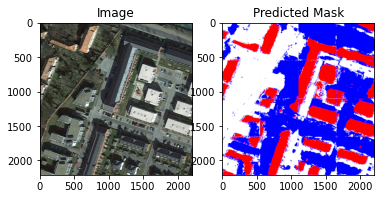

In [28]:
# uncomment model_checkpoint - if you wish to specify the model path manually
checkpoint_dir = max(glob('../models' + "/*"))
model_checkpoint = os.path.join(checkpoint_dir, 'trained_model_end.pth')
# model_checkpoint = "models/20200415-155601/trained_model_end.pth"
print('Model loaded from...', model_checkpoint)
image_path = "../data/raw/berlin/berlin5_image.png"
out_file = "../reports/figures/predict_berlin5_mask.png"
crop_image, predicted_image = predict(model_checkpoint, image_path, out_file)

plt.subplot(1, 2, 1)
plt.imshow(crop_image)
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Predicted Mask')

plt.show()


# A web based app based on streamlit app

In [ ]:
os.chdir('../')
!streamlit run apps/app.py

### Summary 

* Based on 640 test set images:

    1. Building IoU on test set =0.6401
    2. Road IoU on test set = 0.4409
    3. BG IoU on test set = 0.6520
    4. mIoU on test set = 0.5776
    5. Frequency weighted IoU on test set = 0.6413
    6. Pixel accuracy on test set = 0.7691

* Although the pixel-wise accuracy looks reasonable, IoU for each class can be increased further.

* From the berlin dataset, it was clearly visible that the classes (Building, Road and BG) are not balanced. To overcome it, I applied weight factor ```['BG': 1, 'Road': 2, 'BG': 0.5]```. These weights can be used to give more importance to the imbalanced classes. Perhaps, the weight factor for ```Road``` could be increased further to increase its IoU. 

* Due to compute resource, I used a variant of U-Net (quarter the features maps than the original). Probably, by switching to original U-Net a bit of performance gain can be improved.

**Next steps:**

* Increase the number of iterations/epochs. The above result is just based on 10 epochs (due to limited compute resource). 

* Adding image augmentation like zooming and changing angles, rotation etc to provide wide situations for training. This could help in creating the model that is more smart to recognize the buildings, roads and BG in different situations. And it also increases the number of images in data which directly proportional to the good prediction of result.

* Replace the variant of U-Net with original U-Net architecture.

* Build U-Net with backbone architecures (VGG, ResNet, DenseNET, EfficientNet, etc.) as a encoder part. In this way, pretrained weights can be used to fine-tune the model. 